# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [98]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [99]:
flist = ['GunPoint'] # List dataset directory names.
k = 4 # For k-fold cross validation. If k=1, the original test-train split is used.
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
# Directories
fdir = '../data'  
logs_dir = '../logs'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [100]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import time
from datetime import datetime
import pathlib

np.random.seed(22)#813306)

      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  
nb_epochs = 5000

### Visualise the data

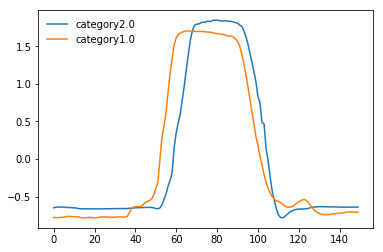

In [101]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [102]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    batch_size = int(min(x_train.shape[0]/10, 16))
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
     
   # x_test_min = np.min(x_test, axis = 1, keepdims=1)
   # x_test_max = np.max(x_test, axis = 1, keepdims=1)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    #x_train = x_train.reshape(x_train.shape + (1,))
    #x_test = x_test.reshape(x_test.shape + (1,))
    
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
     
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), 
                #callbacks = [TestCallback((x_train, Y_train)), reduce_lr, keras.callbacks.TensorBoard(log_dir='./log'+fname, histogram_freq=1)])
                 callbacks=[reduce_lr])
    end = time.time()
    
    log = pd.DataFrame(hist.history)
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    duration_minutes = str(round((end-start)/60))
    print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')
    print('Selected the test result with the lowest training loss. Loss and accuracy are -')
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc)
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+  fname +'  |'+ timestamp + '  |' + duration_minutes + 'mins  |'
    # Save log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    return summary
 



# Train

In [103]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = KFold(k, True, k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
for each in results:
    print(each)
	

Running dataset GunPoint
Train on 150 samples, validate on 50 samples
Epoch 1/1
 - 1s - loss: 0.6838 - acc: 0.5467 - val_loss: 0.6457 - val_acc: 0.6200
Training complete on GunPoint
Training time  1.768704891204834 seconds, which is about 0 minutes.
Selected the test result with the lowest training loss. Loss and accuracy are -
0.6838244557380676 0.6200000196695328
For the results table -
|0  |0.6838244557380676  |0.6200000196695328 |GunPoint  |2018-11-23T13:43  |0mins  |
Saving logs to ../logs/2018-11-23T13:43/GunPoint/history_0.csv
Running dataset GunPoint
Train on 150 samples, validate on 50 samples
Epoch 1/1
 - 2s - loss: 0.6729 - acc: 0.6400 - val_loss: 0.6685 - val_acc: 0.6000
Training complete on GunPoint
Training time  1.8946590423583984 seconds, which is about 0 minutes.
Selected the test result with the lowest training loss. Loss and accuracy are -
0.6728577733039856 0.6000000149011612
For the results table -
|1  |0.6728577733039856  |0.6000000149011612 |GunPoint  |2018-11-23

# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |

### K-fold cross validation
|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1.0  | 2.058348101741103e-07   | 1.0  |  .| 2018-11-23T12:51   |
|1.1   | 2.7934738824342274e-07   | 0.9400000035762787  |  .| 2018-11-23T12:51   |
|1.2   | 2.1417950222257786e-07   | 0.9200000047683716  |  .| 2018-11-23T12:51   |
|1.3   | 1.9788750762472774e-07   | 0.9800000011920929  |  .| 2018-11-23T12:51   |


# Read results from file

In [104]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history_0.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history_0.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-11-23T13:43/GunPoint/history_0.csv - loss and val_acc are
0.6838244557380676 0.6200000196695328
